In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import pylab as p
import numpy as np
import sys
import os
import re 
from scipy.spatial import ConvexHull

In [2]:
#modified by @flomin
# I have rewritten the "read_bc" function
def read_bc(f):
    bc1 = []
    bc2 = []
    bc3 = []
    bc4 = []
    for i in range(1):
        f.readline()
    ###	
    line = True
    while line:
        string = f.readline()
        if re.search(r'ELSET=SS1_',string):
            s=f.readline().split()
            # print len(s)
#             print (s[0])
            while s[0] != '*SURFACE,' or s[0] != '*ELSET,' :
                if s[0] == '*ELSET,' :
                    s=f.readline().split()
                    continue
                #print s[0]
                if len(s) == 1:
                    bc1.append(s[0])
                else:
                    for j in range(len(s)):
                       bc1.append(s[j].strip(',').strip(' '))
                s=f.readline().split()
                if s[0] == '*SURFACE,':
                    break
            continue
        if re.search(r'ELSET=SS2_',string):
            s=f.readline().split()
            while s[0] != '*SURFACE,' or s[0] != '*ELSET,' :
                if s[0] == '*ELSET,' :
                    s=f.readline().split()
                    continue
                if len(s) == 1:
                    bc2.append(s[0])
                else:
                    for j in range(len(s)):
                        bc2.append(s[j].strip(',').strip(' '))
                s=f.readline().split()
                if s[0] == '*SURFACE,':
                    break
            continue
        if re.search(r'ELSET=SS3_',string):
            s=f.readline().split()
            while s[0] != '*SURFACE,' or s[0] != '*ELSET,' :
                if s[0] == '*ELSET,' :
                    s=f.readline().split()
                    continue
                if len(s) == 1:
                    bc3.append(s[0])
                else:
                    for j in range(len(s)):
                        bc3.append(s[j].strip(',').strip(' '))
                s=f.readline().split()
                if s[0] == '*SURFACE,':
                    break
            continue
        if re.search(r'ELSET=SS4_',string):
            s=f.readline().split()
            while s[0] != '*SURFACE,' or s[0] != '*ELSET,' :
                if s[0] == '*ELSET,' :
                    s=f.readline().split()
                    continue
                if len(s) == 1:
                    bc4.append(s[0])
                else:
                    for j in range(len(s)):
                        bc4.append(s[j].strip(',').strip(' '))
                s=f.readline().split()
                if s[0] == '*SURFACE,':
                    break
            continue   
        if re.search(r'^\*SURFACE,',string) or re.search(r'^SS[0-9]+_E[0-9]+,$',string):
            continue
        if re.search(r'^\*\*',string):
            line = False
            break            

#     print ('Boundary elements   ',)
#     print (bc1, bc2, bc3, bc4); print();
    return bc1, bc2, bc3, bc4           
###

In [3]:

def read_nodes(filename,Nmat):
# 	print ("Opening file", filename)
	f = open(filename,'r')
	for i in range(9):
		f.readline()
	#
	node_id = []
	nodes_x = []
	nodes_z = []

	# Reading node id and coordinates
	line = True
	while line:
		string = f.readline().split()
		if string[0] != '**':
			node_id.append(int(string[0].strip(',').strip(' ')))
			nodes_x.append(string[1].strip(',').strip(' '))
			nodes_z.append(string[2].strip(',').strip(' '))
		else:
			line=False
	###
# 	print ('Number of nodes                   :', len(nodes_x))


	###
	###
	for i in range(2): 	f.readline()
	#
	# Reading elements
	node1=[];node2=[];node3=[];node4=[];tags=[]; elem_tag=[];


	for mat in range(Nmat):
		line = True
		while line:
			string = f.readline().split()
			if string[0] != '**' and string[0] != '*ELEMENT,' :
				elem_tag.append(string[0].strip(',').strip(' '))

				node1.append(string[1].strip(',').strip(' '))
				node2.append(string[2].strip(',').strip(' '))
				node3.append(string[3].strip(',').strip(' '))
				node4.append(string[4].strip(',').strip(' '))

				tags.append(str(mat+1))
			else:
				line=False
		###
	###

# 	print ('Number of elements                :', len(node1))


	# Putting in order here !
	nelem = len(node1)
	nodes = np.zeros((5,nelem))
	for i in range(nelem):
		elem = int(elem_tag[i])-1
		nodes[0,elem] = int(node1[i])
		nodes[1,elem] = int(node2[i])
		nodes[2,elem] = int(node3[i])
		nodes[3,elem] = int(node4[i])
		nodes[4,elem] = int(tags[i])
	###

	# !!!
	# In my meshes, I start numerotation of everything (node, elem, mat) with 1.
	# In Nepal mesh, min node number is 2, so I correct it manually here!
	shift = 1- min(node_id)
	nodes[0,:] += shift
	nodes[1,:] += shift
	nodes[2,:] += shift
	nodes[3,:] += shift



	###
	# Boundary elements
	bc1,bc2,bc3,bc4 = read_bc(f)	

	return node_id, nodes_x, nodes_z, nodes, bc1, bc2, bc3, bc4
###

In [4]:
def  order_nodes_for_ours (elem_nodes, x_nodes, z_nodes ):
	
	
	# print '*Given element nodes   ', elem_nodes[0:4]
	# Checking jacobien (pour voir le sens de numerotation)
	eti1 = int(elem_nodes[0])-1
	eti2 = int(elem_nodes[1])-1
	eti3 = int(elem_nodes[2])-1
	eti4 = int(elem_nodes[3])-1

	xv1  = float(x_nodes[eti2])-float(x_nodes[eti1])
	xv2  = float(x_nodes[eti3])-float(x_nodes[eti2])
	zv1  = float(z_nodes[eti2])-float(z_nodes[eti1])
	zv2  = float(z_nodes[eti3])-float(z_nodes[eti2])
	jac = -xv2*zv1+ xv1*zv2

	new_nodes = np.zeros(4)
	# To modify this part for more combinations !
	if jac<0:
		# print 'JACOBIAN NEGATIVE !';print
		new_nodes[0] = elem_nodes[3]
		new_nodes[1] = elem_nodes[2]
		new_nodes[2] = elem_nodes[1]
		new_nodes[3] = elem_nodes[0]
		# check if stop exists in python
		sys.exit()
	else:
		new_nodes[0] = elem_nodes[0]
		new_nodes[1] = elem_nodes[1]
		new_nodes[2] = elem_nodes[2]
		new_nodes[3] = elem_nodes[3]
	###


	# print '*New element nodes     ', new_nodes[0:4]
	# print

	# Checking if the 1st point is the one we're looking for
	z_list = []
	z_list.append(float(z_nodes[int(new_nodes[0])-1]))
	z_list.append(float(z_nodes[int(new_nodes[1])-1]))
	z_list.append(float(z_nodes[int(new_nodes[2])-1]))
	z_list.append(float(z_nodes[int(new_nodes[3])-1]))
	z_list = sorted (z_list)

	zmin_loc1 = z_list[0]
	zmin_loc2 = z_list[1]

	# print 'Sorted list of z values            ', z_list
	# print '2 Minimum values on the element:   ', zmin_loc1, zmin_loc2

	count1 = 0; count2=0
	local1 = []; local2 =[]
	for i in range(4):
		zloc = float(z_nodes[  int(new_nodes[i])-1  ])

		if ( zloc ==  float(zmin_loc1)  ):
			count1 = count1+1
			local1.append( int(new_nodes[i])  )
			# print 'count1 zloc zmin1'
			# print count1, zloc, local1

		if ( zloc ==  float(zmin_loc2)      ):
			count2 = count2+1
			local2.append( int(new_nodes[i])  )
			# print 'count2 zloc zmin1'
			# print count2, zloc, local2		

		##
	###

	# If only 1 point has z_min
	if      count1 == 1   and count2==1:
		x1   = float(x_nodes[ int(local1[0])-1 ]) 
		x2   = float(x_nodes[ int(local2[0])-1 ]) 		
		if (x1 < x2):
			loc1 = local1[0]
		else:
			loc1 = local2[0]

	elif    count1 == 2:
		x1   = float(x_nodes[ int(local1[0])-1 ]) 
		x2   = float(x_nodes[ int(local1[1])-1 ]) 
		if (x1 < x2):
			loc1 = local1[0]
		else:
			loc1 = local1[1]
    #modified by flomin
	elif    count2 == 2:
		x1   = float(x_nodes[ int(local2[0])-1 ])
		x2   = float(x_nodes[ int(local2[1])-1 ])
		loc1 = local1[0]

	else:
		print ('Too many vertices with same z-coordinate')
	###

	new_nodes2 = np.zeros(4)

	# 1st case
	if      loc1 == int(new_nodes[1]):
		new_nodes2[0] = new_nodes[1]
		new_nodes2[1] = new_nodes[2]
		new_nodes2[2] = new_nodes[3]
		new_nodes2[3] = new_nodes[0]

	elif    loc1 == int(new_nodes[2]):
		new_nodes2[0] = new_nodes[2]
		new_nodes2[1] = new_nodes[3]
		new_nodes2[2] = new_nodes[0]
		new_nodes2[3] = new_nodes[1]

	elif    loc1 == int(new_nodes[3]):
		new_nodes2[0] = new_nodes[3]
		new_nodes2[1] = new_nodes[0]
		new_nodes2[2] = new_nodes[1]
		new_nodes2[3] = new_nodes[2]
	else:
		new_nodes2[0] = new_nodes[0]
		new_nodes2[1] = new_nodes[1]
		new_nodes2[2] = new_nodes[2]
		new_nodes2[3] = new_nodes[3]		
	###

	# print 'Sorted element    ', int(new_nodes2[0]),int(new_nodes2[1]),int(new_nodes2[2]),int(new_nodes2[3])
	return int(new_nodes2[0]),int(new_nodes2[1]),int(new_nodes2[2]),int(new_nodes2[3])
###


In [5]:

def create_our_mesh2d(newfile,nodes_x,nodes_z,nodes,bc1,bc2,bc3,bc4):

	nodes_sorted = np.zeros(nodes.shape)

	nel   = len(nodes[0,:])
	nnode = len(nodes_x)
	nbc   = 4

	f = open(newfile, 'w')
	f.write('NEL NPEL NNOD NBC \n')
	f.write('%s \t %s \t %s \t %s \n' %   (str(nel), str(4), str(nnode), str(nbc))  )

	f.write('NID X Y \n')
	for  i in range(nnode):
		f.write('%s \t %s \t %s \n' %   (str(i+1), nodes_x[i], nodes_z[i])  )
	#

	f.write('EID NODES TAG \n')
	for i in range(nel):
		# print 'Element    ', i+1
		node1, node2, node3, node4 = order_nodes_for_ours (nodes[:,i], nodes_x, nodes_z )
# 		print
		f.write('%s \t %s \t %s \t %s \t %s \t %s \n' %   (str(i+1), str(int(node1)), 
			str(int(node2)), str(int(node3)), str(int(node4)), str(int(nodes[4,i]))))


		nodes_sorted[0,i] = node1
		nodes_sorted[1,i] = node2
		nodes_sorted[2,i] = node3
		nodes_sorted[3,i] = node4


	###
  
    # modified by @flomin
    # this is where I use the link between the edge and sidesets
    # edge1 correspond to the elements in the sideset of bc["e1"]
    # edge2 correspond to the elements in the sideset of bc["e2"]
    # edge3 correspond to the elements in the sideset of bc["e3"]
    # edge4 correspond to the elements in the sideset of bc["e4"]
    
	# BC 1
	edge = 1
	f.write('BCTAG NBEL \n')
	f.write('%s \t %s \n' % (str(edge), str(len(bc1)) ) )
	f.write('BID EID EDGE  \n')				
	for i in range(len(bc1)):
		f.write('%s \t %s \t %s  \n' % (str(i+1), bc1[i], str(edge)) )
	
	# BC 2
	edge = 2
	f.write('BCTAG NBEL \n')
	f.write('%s \t %s \n' % (str(edge), str(len(bc2)) ) )	
	f.write('BID EID EDGE  \n')				
	for i in range(len(bc2)):
		f.write('%s \t %s \t %s  \n' % (str(i+1), bc2[i], str(edge)) )

	# BC 3
	edge = 3
	f.write('BCTAG NBEL \n')
	f.write('%s \t %s \n' % (str(edge), str(len(bc3)) ) )	
	f.write('BID EID EDGE  \n')				
	for i in range(len(bc3)):
		f.write('%s \t %s \t %s  \n' % (str(i+1), bc3[i], str(edge)) )

	# BC 4
	edge = 4
	f.write('BCTAG NBEL \n')
	f.write('%s \t %s \n' % (str(edge), str(len(bc4)) ) )	
	f.write('BID EID EDGE  \n')				
	for i in range(len(bc4)):
		f.write('%s \t %s \t %s  \n' % (str(i+1), bc4[i], str(edge)) )
	#
	f.close()

	return nodes_sorted
###


In [6]:
def plot_mesh_elements(nodes, nodes_x, nodes_z, mod=10):

    # Drawing the 2D shape
    fig = plt.figure(figsize=(8,6)); 
    ax = fig.add_subplot(111)

    nel = len(nodes[0,:])
    for i in np.arange(0,nel,1):
        if i%mod == 0: print ('*** Element ', i)
        points = []
        for j in [0,1,2,3]:
            points.append( [float(nodes_x[int(nodes[j,i])-1]), float(nodes_z[int(nodes[j,i])-1])] )
        points = np.array(points)
        hull = ConvexHull(points)

        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    plt.show()
###





# SCATTER PLOT TO GAIN TIME
def plot_mesh_nodes_quickly(nodes_sorted, nodes_x, nodes_z):

    # ALL NODES
    node_list  = [int(node) for node in nodes_sorted[0,:]]
    node_list += [int(node) for node in nodes_sorted[1,:]]
    node_list += [int(node) for node in nodes_sorted[2,:]]
    node_list += [int(node) for node in nodes_sorted[3,:]]
    # print ('Associated nodes: ', node_list)

    # Remove repeated nodes
    node_list = list(set(node_list))
    print ('Number of associated nodes:', len(node_list))




    # PLOT
    fig = plt.figure(figsize=(10,6)); #set_style(whitegrid=True, scale=0.75)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Length (m)')
    ax.set_ylabel('Depth (m)')
    # ax.set_title('Elements tagged with Material #'+ str(tags_mat[0]))


    nodes = [int(node)-1 for node in node_list ]

    xx = [float(nodes_x[int(ii)-1] ) for ii in nodes ]
    zz = [float(nodes_z[int(ii)-1] ) for ii in nodes ]

    ax.scatter(xx, zz, c='k', alpha=1.0, s=1)    
    ###  

    plt.show()




### INPUTS HERE ###

Number of associated nodes: 15076


<IPython.core.display.Javascript object>


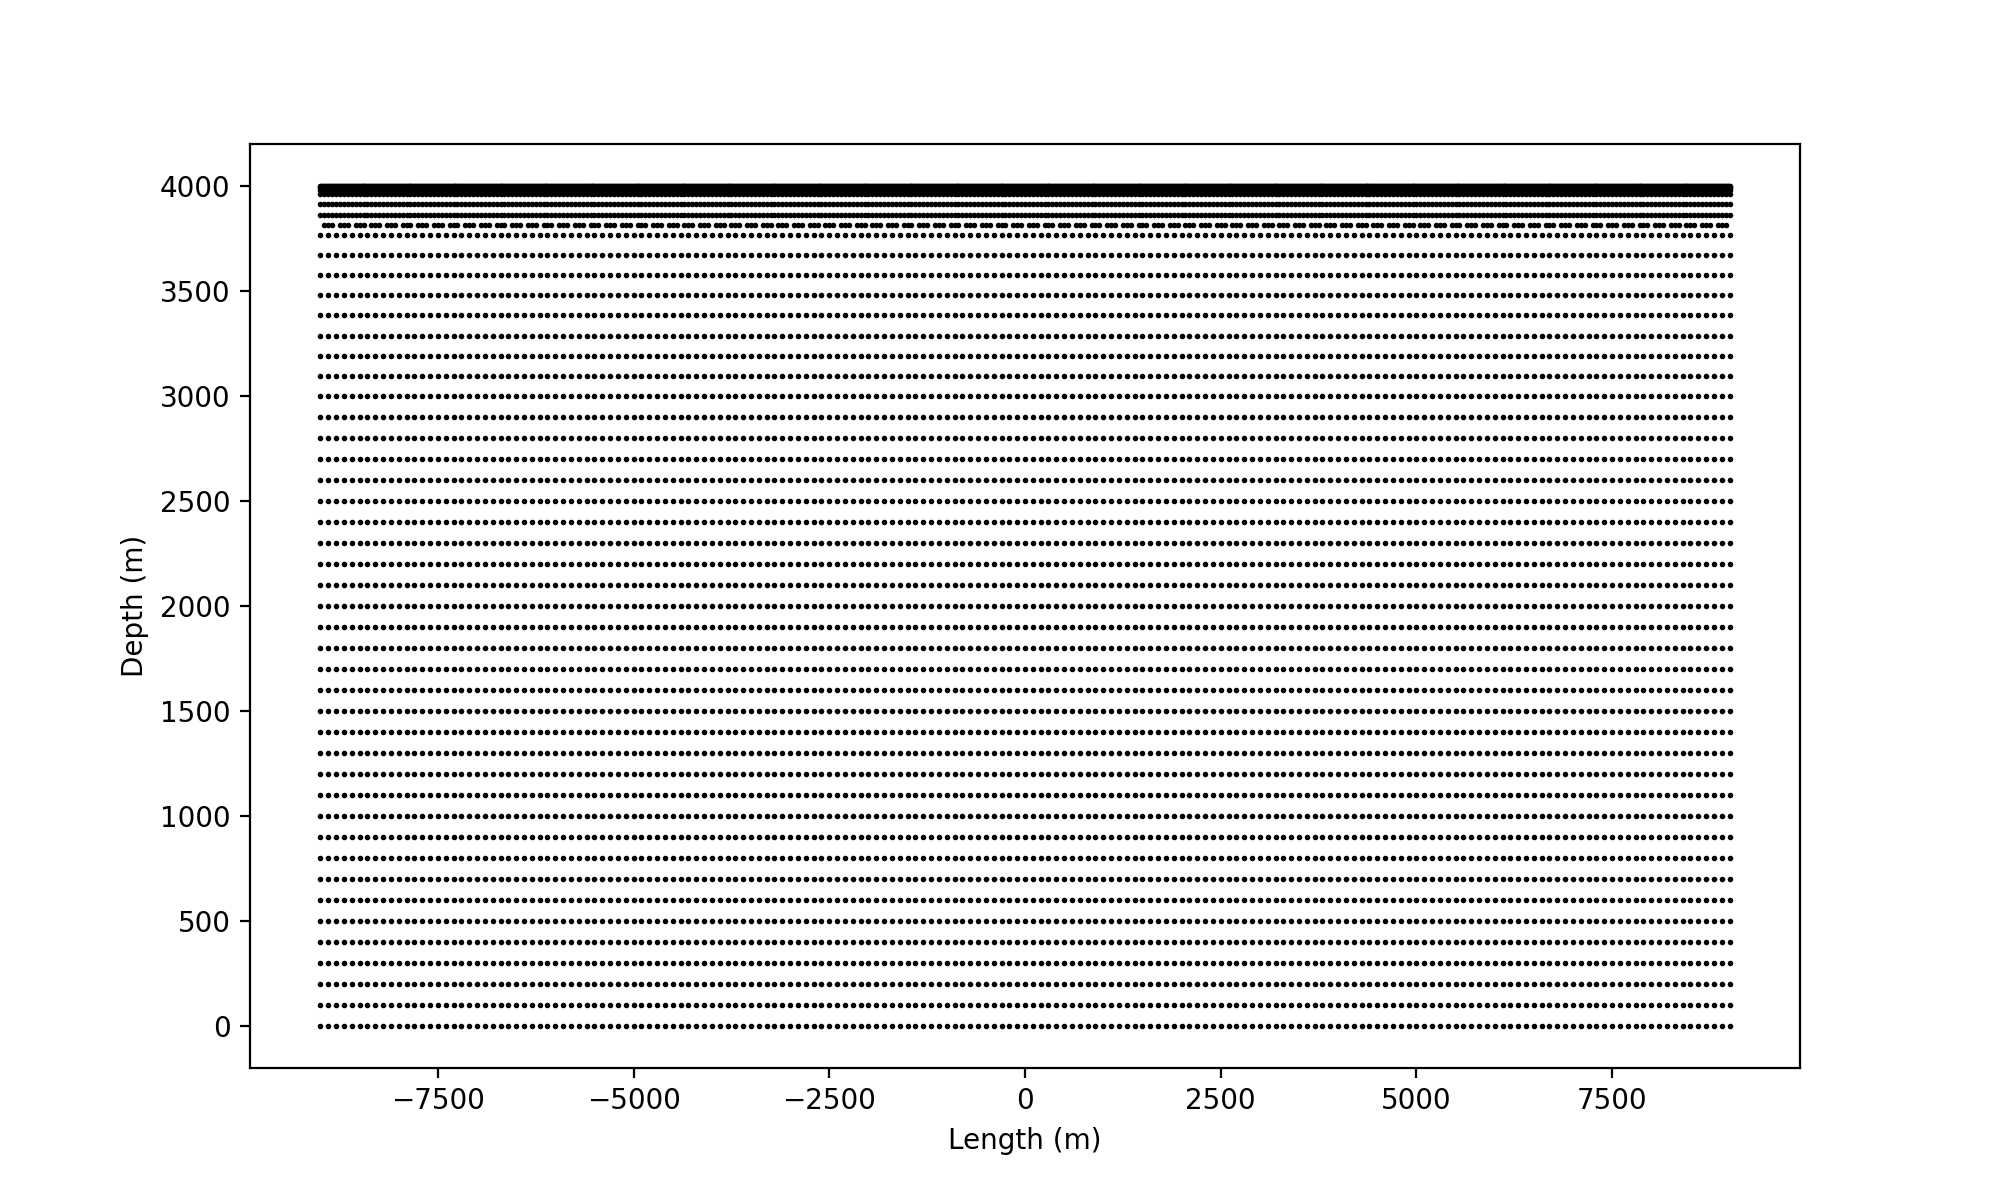

In [7]:
#########################################################################
# MAIN CODE 															#
#########################################################################
# On suppose qu'il y a 4 conditions aux limites !
# We assume that there are 4 boundary cdts!

Nmat = 1
# abaqus file of extension .inp
filename='path_to_abaqus_mesh_file/example_mesh.inp'

# output mesh file for sem2dpack
newfile  = 'path_to_output_sem2dpack_mesh_file/example_mesh.mesh2d'


# Nodes and elements
node_id, nodes_x, nodes_z, nodes, bc1, bc2, bc3, bc4 = read_nodes(filename,Nmat)

# Write out 
nodes_sorted = create_our_mesh2d(newfile,nodes_x,nodes_z,nodes,bc1,bc2,bc3,bc4)


# plot_mesh_elements(nodes, nodes_x, nodes_z)
plot_mesh_nodes_quickly(nodes_sorted, nodes_x, nodes_z)